In [1]:
from autumn.tools.project import get_project, TimeSeriesSet
from autumn.tools.plots.utils import REF_DATE
from autumn.tools.calibration.targets import get_target_series
from autumn.tools.utils.pretty import pretty_print
from summer.utils import ref_times_to_dti

from matplotlib import pyplot as plt
import datetime
import pandas as pd

In [2]:
project = get_project("covid_19", "ho_chi_minh_city")

In [3]:
targets_path = f"../../../autumn/projects/covid_19/vietnam/ho_chi_minh_city/timeseries.json"
ts_set = TimeSeriesSet.from_file(targets_path)

In [4]:
custom_params = project.param_set.baseline#.update({"contact_rate": 0.1,
                                          #         "contact_tracing": {"assumed_trace_prop": 0.05,
                                          #                             "assumed_prev": 1e-3,
                                          #                             "quarantine_infect_multiplier": 0.2,
                                          #                             "floor": 0.01},
                                          #        "testing_to_detection": {"assumed_cdr_parameter": 0.06}})
model = project.run_baseline_model(custom_params)
derived_df = model.get_derived_outputs_df()

##  Test derived output from baseline model

In [5]:
def plot_derived_outputs(requested_outputs):

    # Preparing
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(14, 8))
    for i_out, output in enumerate(requested_outputs):

        # Plotting
        axis = fig.add_subplot(2, 2, i_out + 1)
        axis.plot(derived_df[output])

        try:
            target_dates, target_values = get_target_series(project.calibration.targets, REF_DATE, output)
            axis.scatter(target_dates, target_values, c="k")
        except:
            print(f"targets not available for {output}")

        # Finishing up
        axis.set_title(output)
        axis.set_ylim(bottom=0.)
        if "prop_" in output:
            axis.set_ylim(top=1.)
        plt.setp(axis.get_xticklabels(), rotation=45)
    fig.tight_layout()

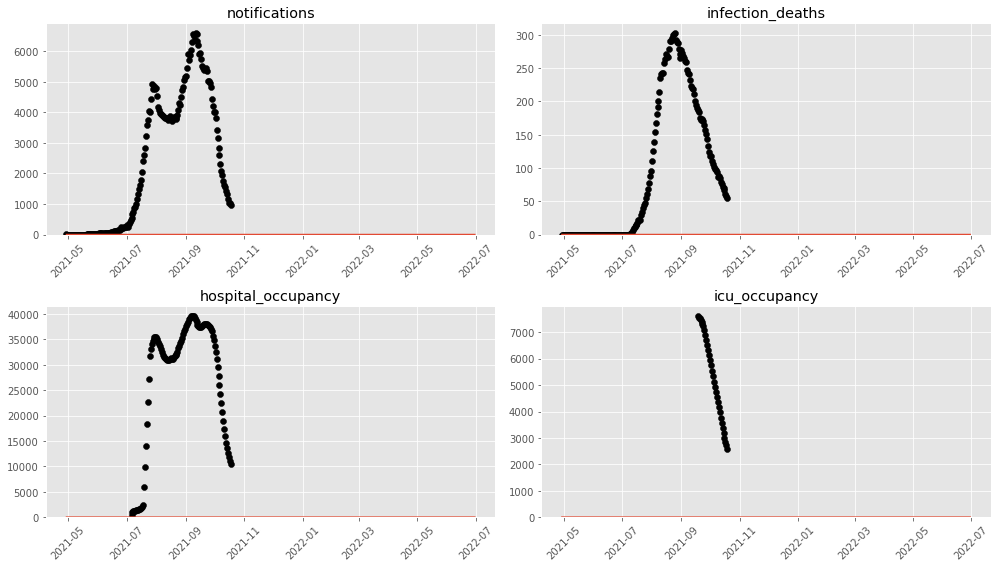

In [6]:
plot_derived_outputs(("notifications", "infection_deaths", "hospital_occupancy", "icu_occupancy"))

### Vaccination coverage

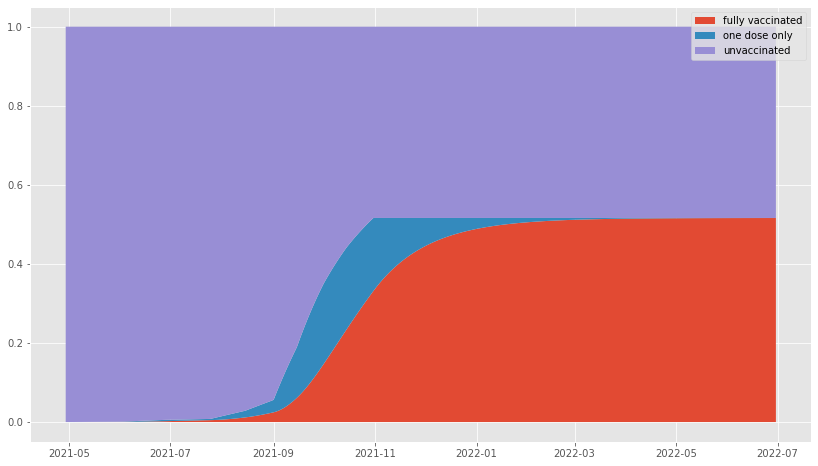

In [7]:
fig = plt.figure(figsize=(14, 8))
axis = fig.add_subplot(1, 1, 1)

axis.fill_between(
    derived_df.index,
    [0.] * len(derived_df),
    derived_df["proportion_fully_vaccinated"],
    label="fully vaccinated"
)
axis.fill_between(
    derived_df.index,
    derived_df["proportion_fully_vaccinated"],
    derived_df["at_least_one_dose_prop"],
    label="one dose only"
)
axis.fill_between(
    derived_df.index,
    derived_df["at_least_one_dose_prop"],
    [1.] * len(derived_df), 
    label="unvaccinated"
)
axis.legend()

targets not available for proportion_seropositive


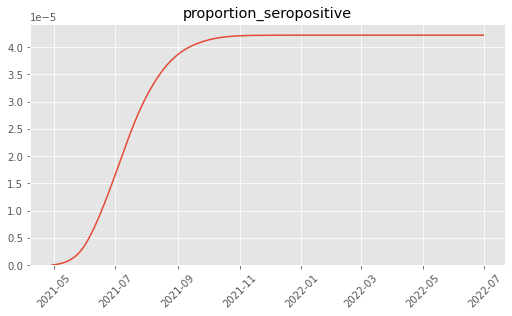

In [8]:
plot_derived_outputs(("proportion_seropositive",))

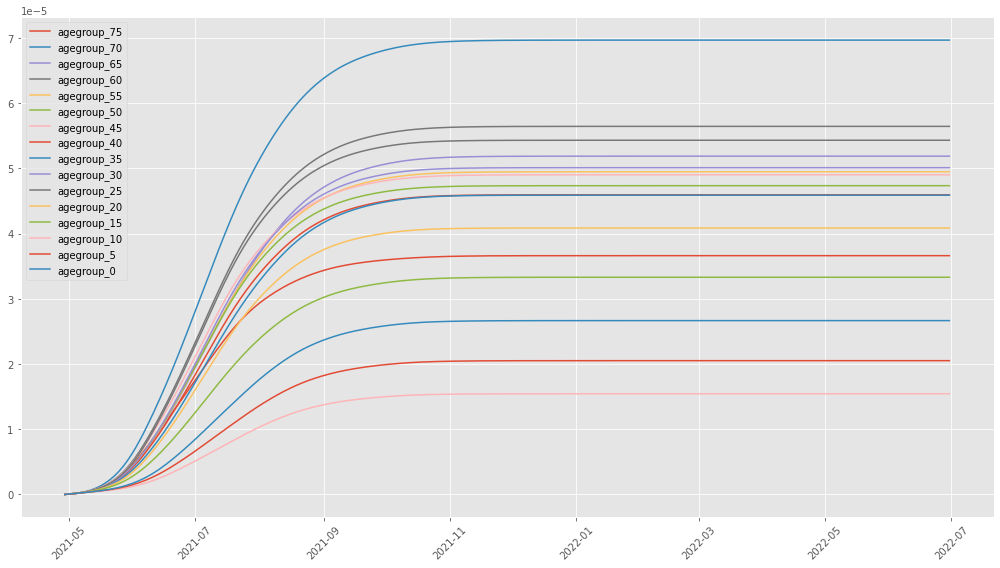

In [9]:
# Preparing
fig = plt.figure(figsize=(14, 8))
axis = fig.add_subplot(1, 1, 1)
requested_outputs = [col for col in derived_df.columns if "proportion_seropositiveX" in col]
for i_out, output in enumerate(requested_outputs):

    # Plotting
    axis.plot(derived_df[output], label=output.split("X")[1])

    # Finishing up
    plt.setp(axis.get_xticklabels(), rotation=45)

axis.legend()
fig.tight_layout()

## Experiment with proposed scenarios 

In [10]:
start_times = [sc_params.to_dict()["time"]["start"] for sc_params in project.param_set.scenarios]
scenarios = project.run_scenario_models(model, project.param_set.scenarios, start_times=start_times)
derived_dfs = [m.get_derived_outputs_df() for m in scenarios]

In [11]:
n_scenarios = len(scenarios)
print(f"Apart from the baseline parameter set, there are a total of {n_scenarios} scenarios run for Ho Chi Minh City.")

Apart from the baseline parameter set, there are a total of 4 scenarios run for Ho Chi Minh City.


In [12]:
outputs = ["notifications", "hospital_occupancy", "icu_occupancy", "infection_deaths"]

plot_first_day = datetime.date(2021, 4, 26)

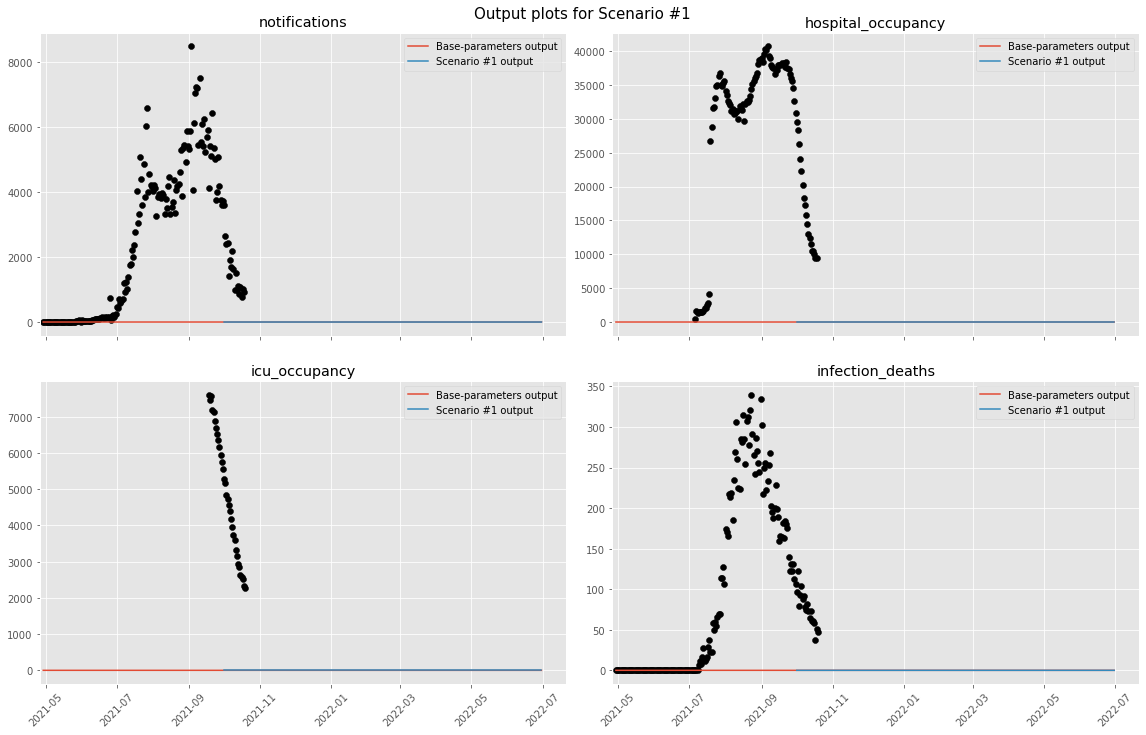

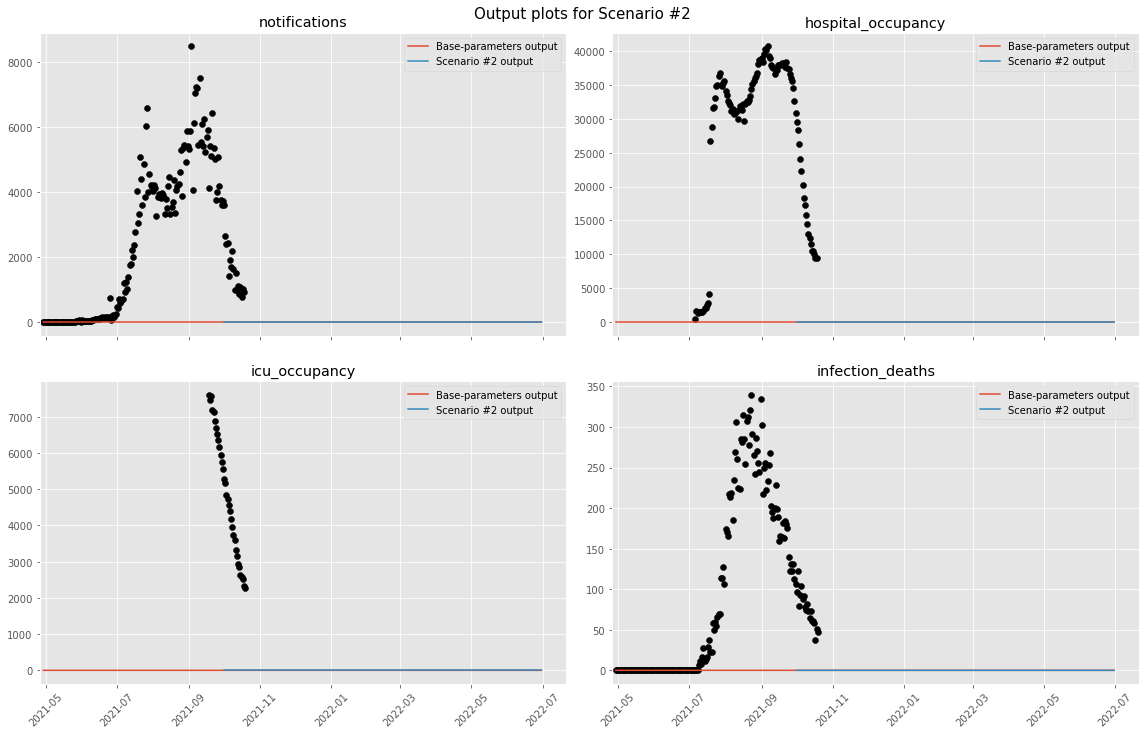

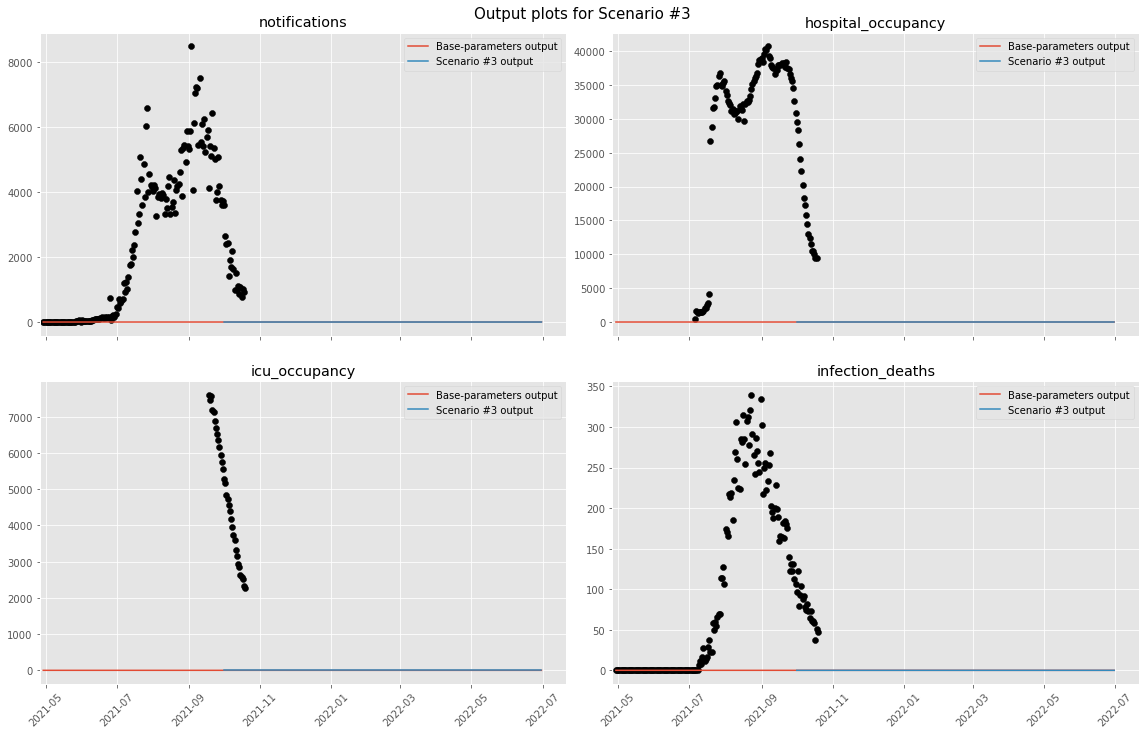

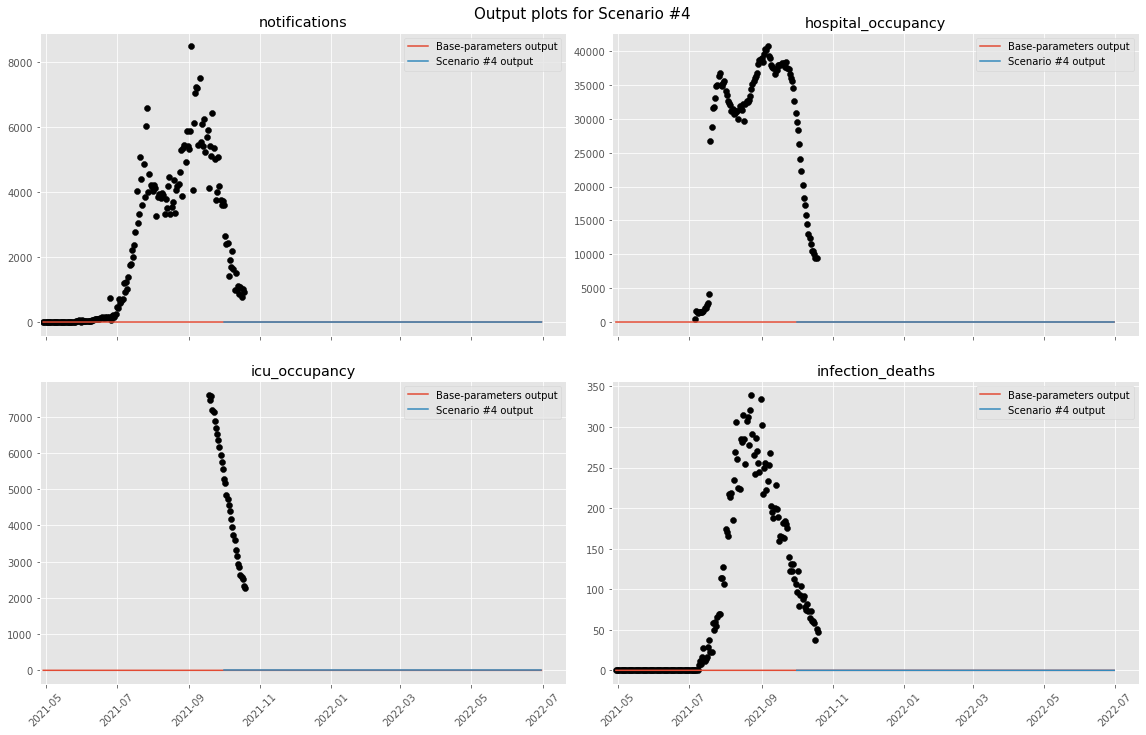

In [13]:
for scenario in range(n_scenarios):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex="all")
    fig.suptitle(f"Output plots for Scenario #{scenario+1}", fontsize=15)
    fig.tight_layout(w_pad=1.5, h_pad=3.5)
    for i_ax, axis in enumerate(axes.reshape(-1)):
        output_name = outputs[i_ax]
        output = ts_set.get(output_name)
        axis.plot(ref_times_to_dti(REF_DATE, model.times), derived_df[outputs[i_ax]], label="Base-parameters output")
        axis.plot(derived_dfs[scenario].index, derived_dfs[scenario][outputs[i_ax]], label=f"Scenario #{scenario+1} output")
        axis.scatter(ref_times_to_dti(REF_DATE, output.times), output.values, c="k")
        axis.tick_params(axis="x", labelrotation=45)
        axis.set_title(output_name)
        axis.set_xlim(left=plot_first_day)
        axis.legend()

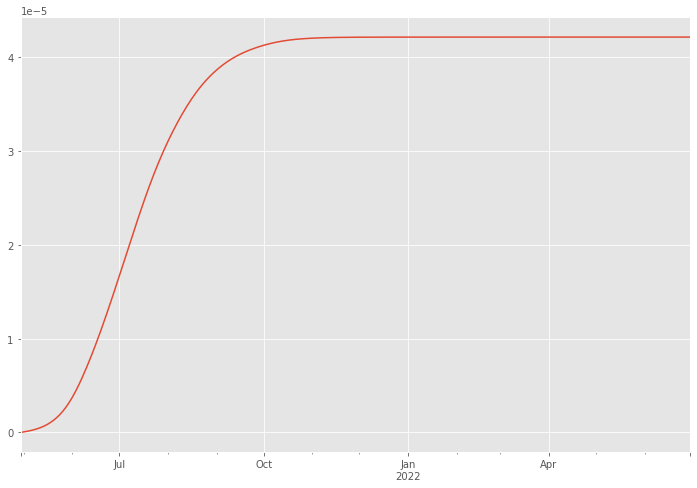

In [14]:
fig = plt.figure(figsize=(12, 8))
plt.style.use("ggplot")
axis = fig.add_subplot()
axis = derived_df["proportion_seropositive"].plot()

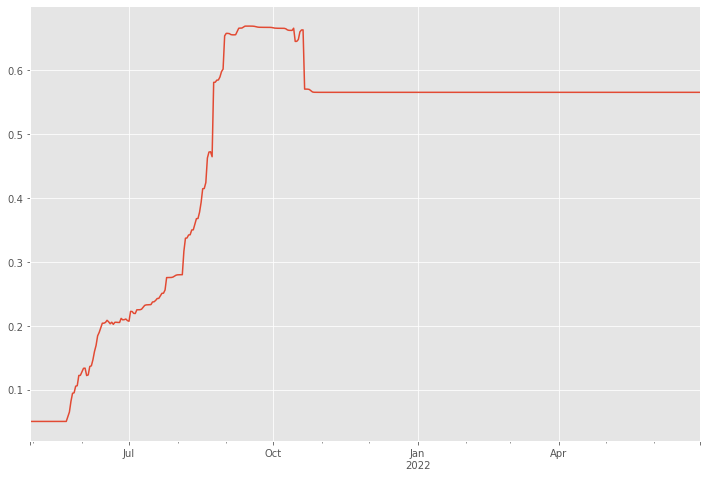

In [15]:
fig = plt.figure(figsize=(12, 8))
plt.style.use("ggplot")
axis = fig.add_subplot()
axis = derived_df["cdr"].plot()